In [1]:
import torch
import torch.nn.functional as F
from src.model import Encoder, Decoder
from src.module import ada_in

In [121]:
encoder = Encoder().to(torch.device("cuda:0")).eval()
decoder = Decoder().to(torch.device("cuda:0")).eval()

encoder.load_state_dict(torch.load("weights/Epoch_51_local_encoder.pth"))
decoder.load_state_dict(torch.load("weights/Epoch_51_decoder.pth"))

# 画像の再構築の可視化

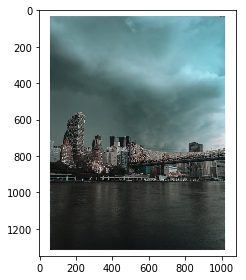

In [122]:
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

image = io.imread("./images/visualmemories_/20184950_333648877089621_8596459317337522176_n.jpg")
io.imshow(image)

In [123]:
from torchvision import transforms
from skimage.transform import resize
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )]
)

image = resize(image, (512, 512))
image = transform(image).float()

In [124]:
_, sensitive_features = encoder(image.unsqueeze(0).to(torch.device("cuda:0")))
_, local_features = encoder(image.unsqueeze(0).to(torch.device("cuda:0")))

decode_image = decoder(sensitive_features)

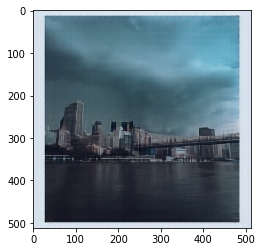

In [125]:
import torchvision.utils as vutils
import numpy as np
def show(img, size=(512, 512)):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(vutils.make_grid(decode_image, normalize=True).cpu().detach())

# 別のLocal Features と Sensitive Featuresの同時分布を用いた画像の再構築

(1349, 1080, 3)


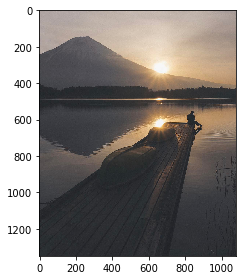

In [126]:
another_image = io.imread("./images/rkrkrk/17266065_229293267534033_6159639669819572224_n.jpg")
io.imshow(another_image)
original_size = another_image.shape
print(original_size)

In [127]:
another_image = resize(another_image, (512, 512))
another_image = transform(another_image).float().to(torch.device("cuda:0"))

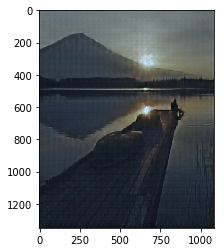

In [128]:
_, local_another_features = encoder(another_image.unsqueeze(0))
joint_features = ada_in(
        local_another_features,
        sensitive_features)

decode_image = decoder(joint_features)
show(vutils.make_grid(
    F.interpolate(decode_image, size=(original_size[0], original_size[1])), normalize=True).cpu().detach())

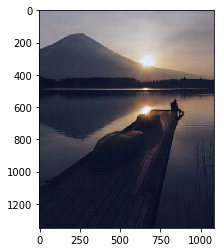

In [129]:
decode_image = decoder(local_another_features)
show(vutils.make_grid(
    F.interpolate(decode_image, size=(original_size[0], original_size[1])), normalize=True).cpu().detach())

# 最も特徴量が近い画像を求める

In [11]:
import random
import glob

file_list = glob.glob("./rkrkrk/*.jpg")
set_file_list = random.sample(file_list, 5)
for file_name in set_file_list:
    print(file_name)
    image = io.imread(file_name)
    io.imshow(image)
    plt.show()

ValueError: Sample larger than population or is negative

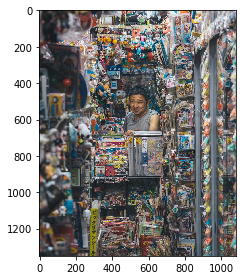

In [96]:
target_file_name = random.choice(file_list)
image = io.imread(target_file_name)
io.imshow(image)
plt.show()

In [91]:
def similarity(set_images, target_image):
    set_features = sensitive_encoder(set_images)
    target_feature = sensitive_encoder(target_image[None, :])
    similarity = F.cosine_similarity(
        set_features.squeeze(), 
        target_feature.squeeze().unsqueeze(0)
    )
    print(similarity)
    return similarity.argmax().item()

tensor([0.9394, 0.8960, 0.9649, 0.9787, 0.4939], device='cuda:0',
       grad_fn=<DivBackward0>)


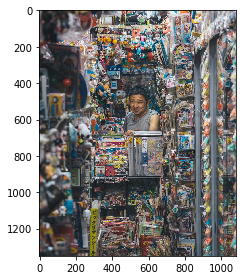

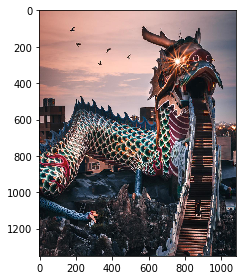

In [97]:
set_images = torch.zeros(len(set_file_list), 3, 224, 224).float()
for i, file_name in enumerate(set_file_list):
    image = io.imread(file_name)
    set_images[i] = transform(resize(image, (224, 224)))
    
image = io.imread(target_file_name)
target_image = transform(resize(image, (224, 224))).float()

index = similarity(set_images.to("cuda:0"), target_image.to("cuda:0"))

# Visualize result
image = io.imread(target_file_name)
io.imshow(image)
plt.show()

image = io.imread(set_file_list[index])
io.imshow(image)
plt.show()